# Analyzing the output of the potential slice generator #

## A NOTE BEFORE STARTING ##

Since the ``prismatique`` git repository tracks this notebook under its original
basename ``analyzing_potential_slice_generator_output.ipynb``, we recommend that
you copy the original notebook and rename it to any other basename that is not
one of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``prismatique`` repository. This way you can explore the notebook by
executing and modifying cells without changing the original notebook, which is
being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Set paths to files storing output](#Set-paths-to-files-storing-output)
- [Load simulation parameter sets and represent them as Python objects](#Load-simulation-parameter-sets-and-represent-them-as-Python-objects)
- [Extracting sample properties](#Extracting-sample-properties)
  - [Extract the sample unit cell dimensions in units of $\mathring{\mathrm{A}}$](#Extract-the-sample-unit-cell-dimensions-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the sample supercell dimensions in units of $\mathring{\mathrm{A}}$](#Extract-the-sample-supercell-dimensions-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the lateral dimensions of the sample supercell in units of pixels](#Extract-the-lateral-dimensions-of-the-sample-supercell-in-units-of-pixels)
  - [Extract the lateral pixel size of the sample supercell in units of $\mathring{\mathrm{A}}$](#Extract-the-lateral-pixel-size-of-the-sample-supercell-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the slice thickness of the sample supercell in units of $\mathring{\mathrm{A}}$](#Extract-the-slice-thickness-of-the-sample-supercell-in-units-of-$\mathring{\mathrm{A}}$)
  - [Extract the number of slices used to partition the sample](#Extract-the-number-of-slices-used-to-partition-the-sample)
  - [Extract the number of frozen phonon configuration subsets](#Extract-the-number-of-frozen-phonon-configuration-subsets)
  - [Extract the number of frozen phonon configurations in each subset](#Extract-the-number-of-frozen-phonon-configurations-in-each-subset)
  - [Extract the total number of frozen phonon configurations](#Extract-the-total-number-of-frozen-phonon-configurations)
- [Loading potential slices](#Loading-potential-slices)
  - [Load slices without grouping into superslices](#Load-slices-without-grouping-into-superslices)
  - [Load slices and group them into superslices](#Load-slices-and-group-them-into-superslices)
  - [Load slices, group them into superslices, and perform lateral average in space](#Load-slices,-group-them-into-superslices,-and-perform-lateral-average-in-space)
  - [Load slices, group them into superslices, perform lateral average in space and thermal average](#Load-slices,-group-them-into-superslices,-perform-lateral-average-in-space-and-thermal-average)

## Import necessary modules ##

In [1]:
# For general array handling.
import numpy as np

# For setting various visualization parameters, and closing figures.
import matplotlib.pyplot as plt



# The library that is the subject of this demonstration. Users may receive a
# warning message about ``pyopencl`` upon importing ``prismatique``. This
# message can be safely ignored.
import prismatique

## Introduction ##

In this notebook, we demonstrate how one can analyze the output generated by the
script ``<root>/examples/potential_slice_generator/generate.py``. Said script
generates: the potential slices of the bilayer $\mathrm{MoS}_2$ sample that we
defined
[here](https://mrfitzpa.github.io/prismatique/examples/atomic_coord_generator/generate.html);
the serialized representations of the sample model parameters, used to generate
the potential slices; and the serialized representation of the simulation
parameters related to GPU and CPU workers, used to generate the potential
slices. For the current notebook to work properly, one must first run the
aforementioned script.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    pyprismatic>=2.0
    jupyter
    ipympl
    prismatique

The easiest way to install these libraries is within a `conda` virtual
environment. It is recommended that `pyprismatic` be installed separately,
prior to installing any of the other Python libraries listed above. GPU
acceleration is available for `pyprismatic` (and thus `prismatique`) if the
following conditions are met:

1. You are using a Linux or Windows machine that has NVIDIA GPUs.
2. A NVIDIA driver is installed with CUDA version 10.2.89 or greater.

If the above conditions have been met, and you would like to be able to use GPUs
with `prismatique`, run the following command:

    conda install -c conda-forge pyprismatic=2.*=gpu* cudatoolkit==<X>.<Y>.*

where `<X>` and `<Y>` are the major and minor versions of CUDA installed on
your machine, e.g. CUDA version 10.2.89 has a major version of `10`, and a
minor version of `2`. Users can omit `cudatoolkit==<X>.<Y>.*` if they do not
require a specific version of `cudatoolkit`, which should apply to most
scenarios. For CPU support only, run the following command instead:

    conda install -c conda-forge pyprismatic=2.*=cpu*

Once `pyprismatic` is installed, you can install the remaining libraries via
`pip` by running the following command:

    pip install prismatique[examples]

or alternatively, via `conda` by running the following command:

    conda install -c conda-forge prismatique ipympl jupyter

You can find the documentation for the `prismatique` library
[here](https://mrfitzpa.github.io/prismatique/_autosummary/prismatique.html). It
is recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `prismatique` that they are currently using.**

## Set paths to files storing output ##

In [2]:
# Path to file storing the potential slices of the frozen phonon configuration
# subset #0.
path_to_potential_slice_subset_0 = \
    "../data/potential_slice_generator_output/potential_slices_of_subset_0.h5"

# Path to file storing the potential slices of the frozen phonon configuration
# subset #1.
path_to_potential_slice_subset_1 = \
    "../data/potential_slice_generator_output/potential_slices_of_subset_1.h5"

# Path to file storing the serialized representation of the sample model
# parameters, used to generate the potential slices.
path_to_sample_model_params = \
    "../data/potential_slice_generator_output/sample_model_params.json"

# Path to file storing the serialized representation of the simulation
# parameters related to GPU and CPU workers, used to generate the potential
# slices.
path_to_worker_params = \
    "../data/potential_slice_generator_output/worker_params.json"

## Load simulation parameter sets and represent them as Python objects ##

In [3]:
# Load serialized representation of the sample model parameters and represent it
# as a Python object.
sample_model_params = \
    prismatique.sample.ModelParams.load(path_to_sample_model_params)

# Load serialized representation of the worker parameters and represent it as a
# Python object.
worker_params = \
    prismatique.worker.Params.load(path_to_worker_params)

## Extracting sample properties ##

See the notebook ``<root>/examples/analyzing_sim_params.ipynb`` for a
demonstration of using the Python representation of the sample model parameters,
``sample_model_params``, to extract various properties of the sample being
modelled. Below we show alternative ways to extract certain properties of the
sample using the files storing the potential slices.

Group the paths to the potential slice files into a Python object.

In [4]:
filenames = \
    (path_to_potential_slice_subset_0, path_to_potential_slice_subset_1)
potential_slice_subset_ids = \
    prismatique.sample.PotentialSliceSubsetIDs(filenames)

### Extract the sample unit cell dimensions in units of $\mathring{\mathrm{A}}$ ###

In [5]:
sample_unit_cell_dims = \
    prismatique.sample.unit_cell_dims(potential_slice_subset_ids)

unformatted_msg = "sample unit cell dimensions (in Å): {}"
msg = unformatted_msg.format(sample_unit_cell_dims)
print(msg)

sample unit cell dimensions (in Å): (22.122800827026367, 21.895893096923828, 15.54092025756836)


### Extract the sample supercell dimensions in units of $\mathring{\mathrm{A}}$ ###

In [6]:
sample_supercell_dims = \
    prismatique.sample.supercell_dims(potential_slice_subset_ids)

unformatted_msg = "sample supercell dimensions (in Å): {}"
msg = unformatted_msg.format(sample_supercell_dims)
print(msg)

sample supercell dimensions (in Å): (22.122800827026367, 21.895893096923828, 15.54092025756836)


### Extract the lateral dimensions of the sample supercell in units of pixels ###

In [7]:
sample_supercell_xy_dims_in_pixels = \
    prismatique.sample.supercell_xy_dims_in_pixels(potential_slice_subset_ids)

unformatted_msg = "lateral dimensions of sample supercell (in pixels): {}"
msg = unformatted_msg.format(sample_supercell_xy_dims_in_pixels)
print(msg)

lateral dimensions of sample supercell (in pixels): (128, 128)


### Extract the lateral pixel size of the sample supercell in units of $\mathring{\mathrm{A}}$ ###

In [8]:
sample_supercell_lateral_pixel_size = \
    prismatique.sample.supercell_lateral_pixel_size(potential_slice_subset_ids)

unformatted_msg = "sample supercell lateral pixel size (in Å): {}"
msg = unformatted_msg.format(sample_supercell_lateral_pixel_size)
print(msg)

sample supercell lateral pixel size (in Å): (0.1728343814611435, 0.1710616648197174)


### Extract the slice thickness of the sample supercell in units of $\mathring{\mathrm{A}}$ ###

In [9]:
sample_supercell_slice_thickness = \
    prismatique.sample.supercell_slice_thickness(potential_slice_subset_ids)

unformatted_msg = "sample supercell slice thickness (in Å): {}"
msg = unformatted_msg.format(sample_supercell_slice_thickness)
print(msg)

sample supercell slice thickness (in Å): 0.9713085293769836


### Extract the number of slices used to partition the sample ###

This can be done in two ways. The first method involves the use of the function
``prismatique.load.num_slices``:

In [10]:
# Could also use ``path_to_potential_slice_subset_1`` as the argument in the
# following function call.
num_slices = prismatique.load.num_slices(path_to_potential_slice_subset_0)

unformatted_msg = "# of sample slices: {}"
msg = unformatted_msg.format(num_slices)
print(msg)

# of sample slices: 16


The second method involves the use of the function
``prismatique.sample.num_slices``:

In [11]:
num_slices = prismatique.sample.num_slices(potential_slice_subset_ids)

unformatted_msg = "# of sample slices: {}"
msg = unformatted_msg.format(num_slices)
print(msg)

# of sample slices: 16


### Extract the number of frozen phonon configuration subsets ###

In [12]:
func_alias = prismatique.sample.num_frozen_phonon_config_subsets
num_frozen_phonon_config_subsets = func_alias(potential_slice_subset_ids)

unformatted_msg = "# frozen phonon configuration subsets: {}"
msg = unformatted_msg.format(num_frozen_phonon_config_subsets)
print(msg)

# frozen phonon configuration subsets: 2


### Extract the number of frozen phonon configurations in each subset ###

This can be done in two ways. The first method involves the use of the function
``prismatique.load.num_frozen_phonon_configs_in_subset``:

In [13]:
func_alias = prismatique.load.num_frozen_phonon_configs_in_subset
filenames = potential_slice_subset_ids.core_attrs["filenames"]

for subset_idx, filename in enumerate(filenames):
    num_frozen_phonon_configs_in_subset = func_alias(filename)
    
    unformatted_msg = "# frozen phonon configurations in subset {}: {}"
    msg = unformatted_msg.format(subset_idx, 
                                 num_frozen_phonon_configs_in_subset)
    print(msg)

# frozen phonon configurations in subset 0: 5
# frozen phonon configurations in subset 1: 5


The second method involves the use of the function
``prismatique.sample.num_frozen_phonon_configs_in_subset``:

In [14]:
func_alias = prismatique.sample.num_frozen_phonon_configs_in_subset

for subset_idx in range(num_frozen_phonon_config_subsets):
    num_frozen_phonon_configs_in_subset = func_alias(potential_slice_subset_ids,
                                                     subset_idx)
    
    unformatted_msg = "# frozen phonon configurations in subset {}: {}"
    msg = unformatted_msg.format(subset_idx, 
                                 num_frozen_phonon_configs_in_subset)
    print(msg)

# frozen phonon configurations in subset 0: 5
# frozen phonon configurations in subset 1: 5


### Extract the total number of frozen phonon configurations ###

In [15]:
func_alias = prismatique.sample.total_num_frozen_phonon_configs
total_num_frozen_phonon_configs = func_alias(potential_slice_subset_ids)

unformatted_msg = "total # of frozen phonon configurations: {}"
msg = unformatted_msg.format(total_num_frozen_phonon_configs)
print(msg)

total # of frozen phonon configurations: 10


## Loading potential slices ##

In the code blocks below, we load subcollections of the potential slices of one
subset.

### Load slices without grouping into superslices ###

Load a potential slice subcollection into a ``hyperspy`` signal.

In [16]:
kwargs = {"filename": path_to_potential_slice_subset_0, 
          "multi_dim_slice": ([2, 3], slice(1, 13, 3)), 
          "num_superslices": 0, 
          "average_thermally": False, 
          "average_laterally_in_space": False}

potential_slice_signal, navigational_to_original_indices_map = \
    prismatique.load.potential_slices(**kwargs)

``navigational_to_original_indices_map`` is a dictionary that maps the
navigational indices of the hyperspy signal ``potential_slice_signal`` to the
original indices specified by ``multi_dim_slice``. For example, if the original
atomic configuration indices map to a set of corresponding navigational indices,
then ``navigational_to_original_indices_map["atomic_config_indices"][i]`` yields
the atomic configuration index specified in the expression
``single_dim_slice=multi_dim_slice[0] if multi_dim_slice is not None else
slice(None)`` that corresponds to the ``i`` th atomic configuration index in the
nagivation index space of ``potential_slice_signal``, where ``i`` is a
nonnegative integer smaller than the total number of atomic configuration
indices specified in ``single_dim_slice``.

In [17]:
navigational_to_original_indices_map

{'atomic_config_indices': (2, 3), 'slice_indices': (1, 4, 7, 10)}

Show the potential slice signal metadata.

In [18]:
potential_slice_signal.metadata

├── General
│   └── title = Potential Slice
├── Prismatique
│   └── slice thickness = 0.9713085293769836
└── Signal
    ├── pixel value units = Å*V
    └── signal_type =

Plot the potential slice subcollection.

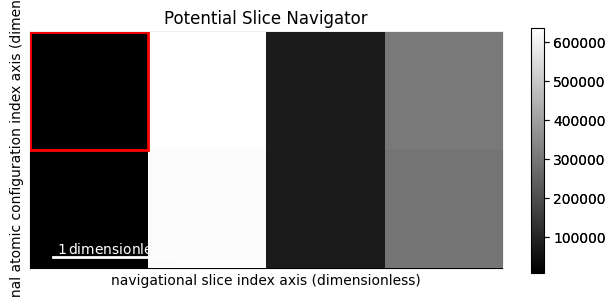

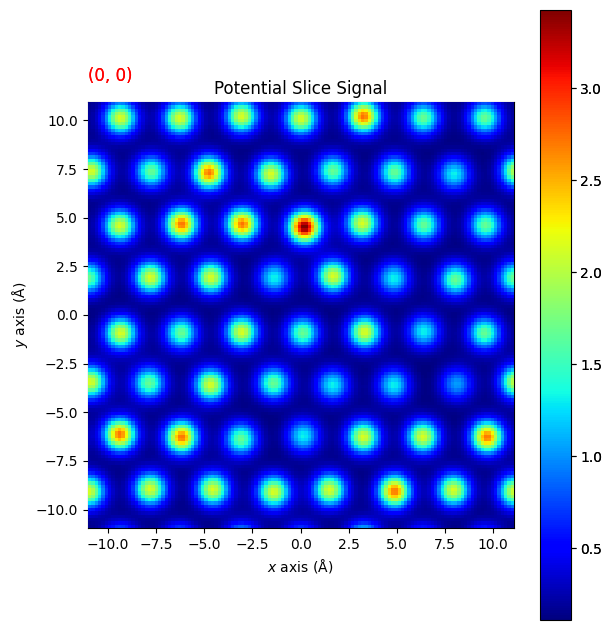

In [19]:
%matplotlib ipympl

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "gamma": 1,
          "cmap": plt.get_cmap("jet")}
potential_slice_signal.plot(**kwargs)

### Load slices and group them into superslices ###

Load a potential slice subcollection into a ``hyperspy`` signal; and group them
into superslices. 

In [20]:
kwargs = {"filename": path_to_potential_slice_subset_0, 
          "multi_dim_slice": None, 
          "num_superslices": 6, 
          "average_thermally": False, 
          "average_laterally_in_space": False}

potential_slice_signal, navigational_to_original_indices_map = \
    prismatique.load.potential_slices(**kwargs)

Show the "navigational to original indices" map.

In [21]:
navigational_to_original_indices_map

{'atomic_config_indices': (0, 1, 2, 3, 4)}

Show the potential slice signal metadata.

In [22]:
potential_slice_signal.metadata

├── General
│   └── title = Potential Superslice
├── Prismatique
│   ├── original slice indices of superslices = ((0, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11), (12, 13, 14), (15,))
│   └── slice thickness = 0.9713085293769836
└── Signal
    ├── pixel value units = Å*V
    └── signal_type =

Plot the potential superslices.

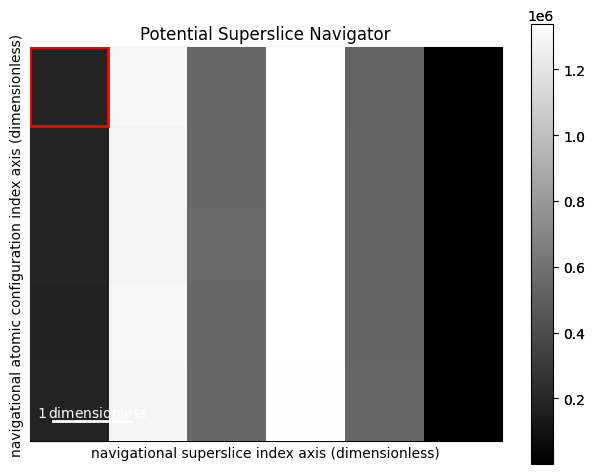

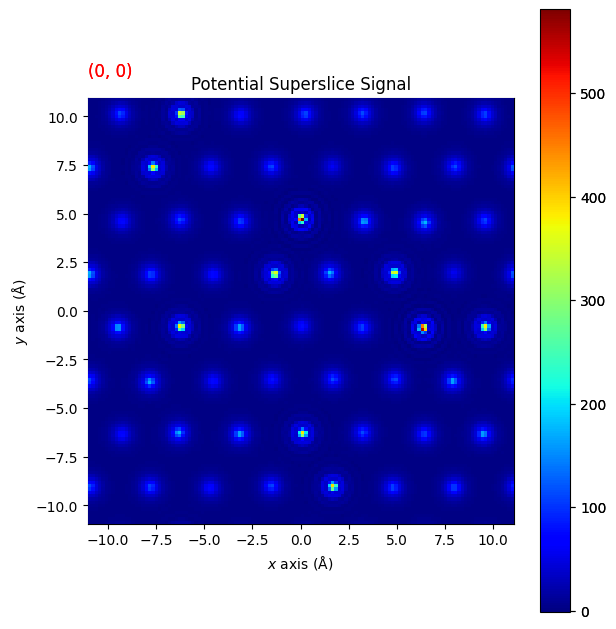

In [23]:
plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "gamma": 1,
          "cmap": plt.get_cmap("jet")}
potential_slice_signal.plot(**kwargs)

### Load slices, group them into superslices, and perform lateral average in space ###

Load a potential slice subcollection into a ``hyperspy`` signal; group them into
superslices; and then perform a lateral average in space.

In [24]:
kwargs = {"filename": path_to_potential_slice_subset_0, 
          "multi_dim_slice": None, 
          "num_superslices": 6, 
          "average_thermally": False, 
          "average_laterally_in_space": True}

potential_slice_signal, navigational_to_original_indices_map = \
    prismatique.load.potential_slices(**kwargs)

Show the "navigational to original indices" map.

In [25]:
navigational_to_original_indices_map

{'atomic_config_indices': (0, 1, 2, 3, 4)}

Show the potential slice signal metadata.

In [26]:
potential_slice_signal.metadata

├── General
│   └── title = Spatially Averaged Potential Superslice
├── Prismatique
│   ├── original slice indices of superslices = ((0, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11), (12, 13, 14), (15,))
│   └── slice thickness = 0.9713085293769836
└── Signal
    ├── pixel value units = Å*V
    └── signal_type =

Plot the spatially averaged potential superslices.

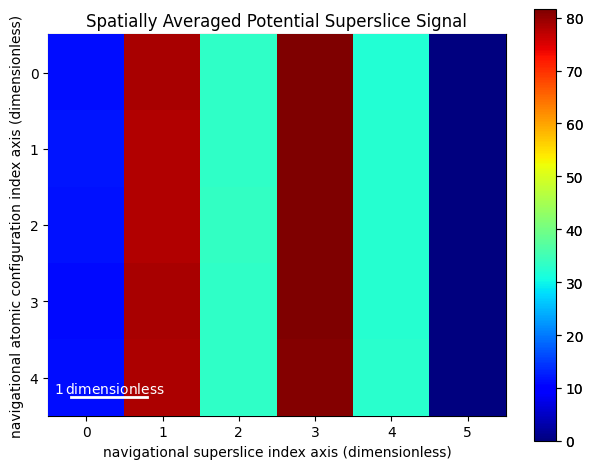

In [27]:
%matplotlib inline

plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "vmin": 0,
          "vmax": None,
          "cmap": plt.get_cmap("jet")}
potential_slice_signal.plot(**kwargs)

### Load slices, group them into superslices, perform lateral average in space and thermal average ###

Load a potential slice subcollection into a ``hyperspy`` signal; group them into
superslices; and then perform a lateral average in space and thermal average.

In [28]:
kwargs = {"filename": path_to_potential_slice_subset_0, 
          "multi_dim_slice": None, 
          "num_superslices": 6, 
          "average_thermally": True, 
          "average_laterally_in_space": True}

potential_slice_signal, navigational_to_original_indices_map = \
    prismatique.load.potential_slices(**kwargs)

Show the "navigational to original indices" map.

In [29]:
navigational_to_original_indices_map

{}

Show the potential slice signal metadata.

In [30]:
potential_slice_signal.metadata

├── General
│   └── title = Thermally and Spatially Averaged Potential Superslice
├── Prismatique
│   ├── original atomic configuration indices = (0, 1, 2, 3, 4)
│   ├── original slice indices of superslices = ((0, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11), (12, 13, 14), (15,))
│   └── slice thickness = 0.9713085293769836
└── Signal
    ├── pixel value units = Å*V
    └── signal_type =

Plot the thermally and spatially averaged potential superslices.

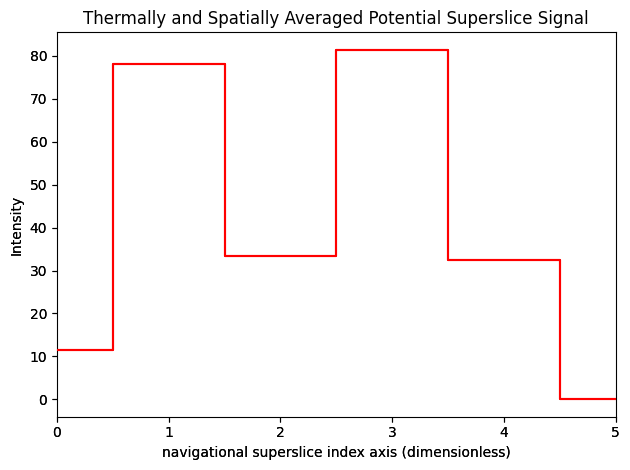

In [31]:
kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "vmin": 0,
          "vmax": None,
          "cmap": plt.get_cmap("jet")}
potential_slice_signal.plot(**kwargs)